In [189]:
%matplotlib inline

In [195]:
import numpy as np
import astropy
from astropy.table import Table 
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from importlib import reload
import sys
sys.path.insert(0,'/home/imendoza/alcca/intro/nbody-relaxed') #where my code is. 

In [196]:
#my packages
import plotting
from plotting import to_latex, scatter_binning, binning3d_mass
reload(plotting);

In [197]:
import warnings
warnings.filterwarnings("ignore")

In [198]:
plt.rc("text", usetex=True)

# preamble 

In [185]:
#functions I need to define myself. 
cvir = lambda cat: cat['rvir'] / cat['rs']
phi_l = lambda cat: np.arccos(
    ((cat['A[x]']*cat['Jx'] + cat['A[y]']*cat['Jy'] + cat['A[z]']*cat['Jz'])
     /
    (np.sqrt(cat['A[x]']**2 + cat['A[y]']**2 + cat['A[z]']**2)*np.sqrt(cat['Jx']**2 + cat['Jy']**2 + cat['Jz']**2) )
    )
)
q = lambda cat: (1/2)*(cat['b_to_a'] + cat['c_to_a']);

In [186]:
#information about catalogue (https://www.cosmosim.org/cms/simulations/bolshoi/)
particle_mass = 1.35e8 #Msun
total_particles = 2048**3 
box_size = 250 #Mpc/h

# read

In [9]:
from astropy.io import ascii

In [10]:
filename = '../data/hlist_1.00109.csv'

In [11]:
#100 Mb chunks of maximum memory in each iteration. 
#this returns a generator. 
tbls = ascii.read(filename, format='csv', guess=False,
                 fast_reader={'chunk_size': 100 * 1000000, 'chunk_generator': True})

In [12]:
ftbls = [] 
for i, tbl in enumerate(tbls): 
    tbl.add_column(cvir(tbl), name='cvir')
    tbl.add_column(phi_l(tbl), name='phi_l')
    tbl.add_column(q(tbl), name='q')
    
    ftbls.append(tbl[params])
    if i%10 ==0: 
        print(i)

ftbl = astropy.table.vstack(ftbls)

0
10
20
30
40
50
60
70
80
90
100
110


In [13]:
#only look at things that have at least 1000 particles as several authors suggest. 
#others might be too noisy. 
cat = ftbl[ (np.log10(ftbl['mvir']) > 12) & 
          (ftbl['Spin'] != 0) &
          (ftbl['q'] !=0)]

cat['Xoff'] = cat['Xoff'] / cat['rvir']

In [14]:
#following recommendations from power2011dynamical
#eta = 2 * T/U 
relaxed = (cat['Xoff'] < 0.04)

In [20]:
len(cat[relaxed])

962403

# histograms

(array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06,
        1.e+07, 1.e+08]), <a list of 10 Text yticklabel objects>)

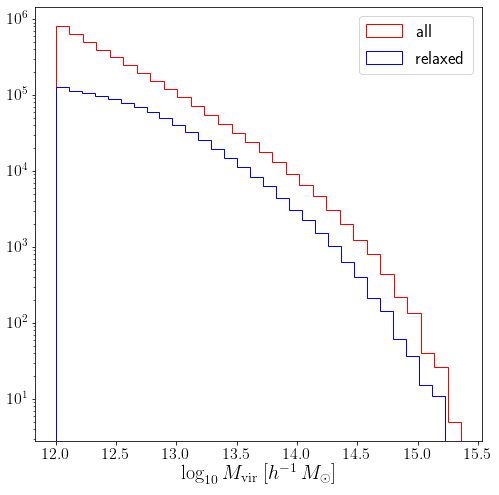

In [237]:
#mass
plt.figure(figsize=(8,8))
plt.hist(np.log10(cat['mvir']), bins=30, histtype='step', label='all', color='r');
plt.hist(np.log10(cat[relaxed]['mvir']), bins=30, histtype='step',color='b', label='relaxed');
plt.xlabel(to_latex('mvir', True, True), size=20)

plt.yscale('log')
plt.legend(prop={'size':18})

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


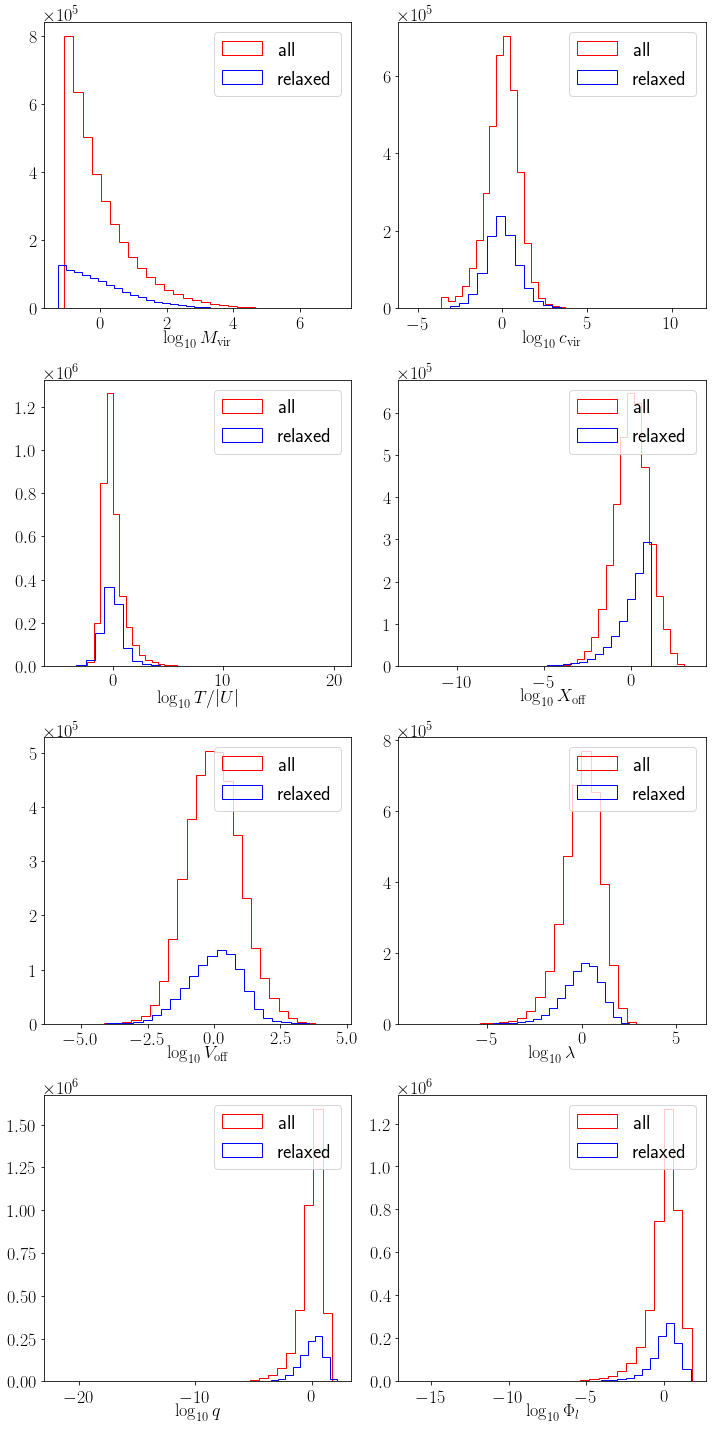

In [239]:
fig, axs = plt.subplots(4, 2, figsize=(10,20))
params = ['mvir', 'cvir' , 'T/|U|', 'Xoff', 'Voff', 'Spin', 'q', 'phi_l']
# print('mean, median, and std of:')
for param, ax in zip(params, axs.flatten()): 
    
    #all halos 
    x = np.log10(cat[param]) 
    px = (x - np.mean(x))/ np.std(x)
    ax.hist(px, histtype='step', bins=30, label='all', color='r')
    
    #relaxed halos 
    x = np.log10(cat[relaxed][param]) 
    px = (x - np.mean(x))/ np.std(x)
    ax.hist(px, histtype='step', bins=30, label='relaxed', color='b')
    ax.set_xlabel(to_latex(param,True), fontsize=18)
    ax.tick_params('both', labelsize=18)
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.yaxis.get_offset_text().set_fontsize(18)

#     print(f'{param}:', np.mean(x), np.median(x), np.std(x))
    
    ax.legend(loc='best', prop={'size':20})

fig.tight_layout() 

# Vanilla Scatters and Contours

correlation: 0.2222424401086844


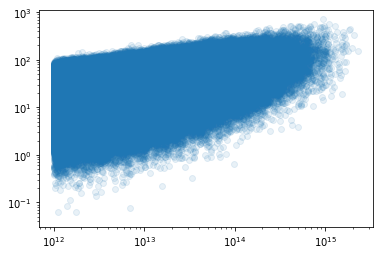

In [12]:
#all masses in catalogue
plt.scatter(cat['mvir'], cat['Xoff'], alpha=0.1)
plt.xscale('log')
plt.yscale('log')
print("correlation:", spearmanr(cat['mvir'], cat['Xoff'])[0])

([<matplotlib.lines.Line2D at 0x2b6adf754978>],
 <matplotlib.contour.QuadContourSet at 0x2b6adf754860>)

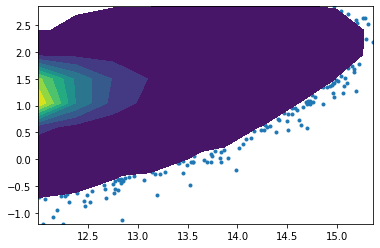

In [13]:
from astroML.plotting import scatter_contour
scatter_contour(np.log10(cat['mvir']), np.log10(cat['Xoff']), filled_contour=True, threshold=100, levels=10)

# correlations

## matrix version

In [34]:
params = ['mvir', 'cvir' , 'T/|U|', 'Xoff', 'Voff', 'Spin', 'q', 'phi_l']
latex_params= [to_latex(param) for param in params]

In [35]:
#prettier version. 
corrs = np.zeros((len(params), len(params)))
for i,param1 in enumerate(params): 
    for j,param2 in enumerate(params):
        corr, p = spearmanr(cat[param1], cat[param2])
        corrs[i,j] = corr

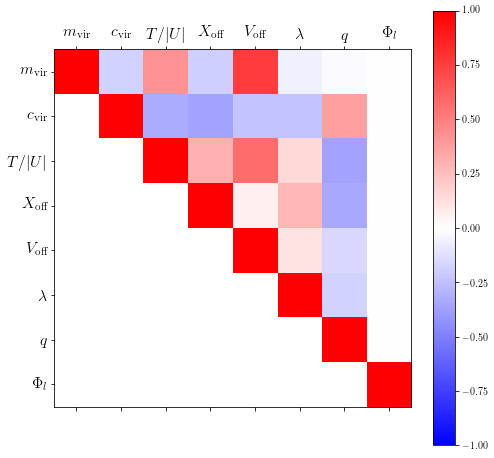

In [36]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
mask =  np.tri(corrs.shape[0], k=-1)
A = np.ma.array(corrs, mask=mask)
im = ax.matshow(A,cmap='bwr',vmin=-1, vmax=1)
plt.colorbar(im, ax = ax)
ax.set_xticklabels(['']+latex_params, size=16);
ax.set_yticklabels(['']+latex_params, size=16);

In [99]:
#print by hand. 
np.set_printoptions(threshold=100)
print(params)
corrs

['mvir', 'cvir', 'Spin', 'q', 'phi_l', 'Xoff', 'T/|U|']


array([[ 1.00000000e+00, -1.75523511e-01,  4.24186949e-01,
         2.22244956e-01,  7.64995259e-01, -6.18789026e-02,
        -2.24490578e-02,  3.67020469e-05],
       [-1.75523511e-01,  1.00000000e+00, -3.21983725e-01,
        -4.36992183e-01, -2.31489169e-01, -2.33150932e-01,
         3.72361875e-01, -1.41476538e-04],
       [ 4.24186949e-01, -3.21983725e-01,  1.00000000e+00,
         4.85937303e-01,  5.76096661e-01,  1.55082099e-01,
        -3.58415604e-01, -1.04685226e-04],
       [ 2.22244956e-01, -4.36992183e-01,  4.85937303e-01,
         1.00000000e+00,  3.65609324e-01,  2.43946891e-01,
        -3.52620598e-01, -9.49937762e-05],
       [ 7.64995259e-01, -2.31489169e-01,  5.76096661e-01,
         3.65609324e-01,  1.00000000e+00,  1.14407555e-01,
        -1.52727061e-01, -1.99328950e-04],
       [-6.18789026e-02, -2.33150932e-01,  1.55082099e-01,
         2.43946891e-01,  1.14407555e-01,  1.00000000e+00,
        -1.77633394e-01,  5.64504122e-05],
       [-2.24490578e-02,  3.723618

## Correlations between parameters, graphically

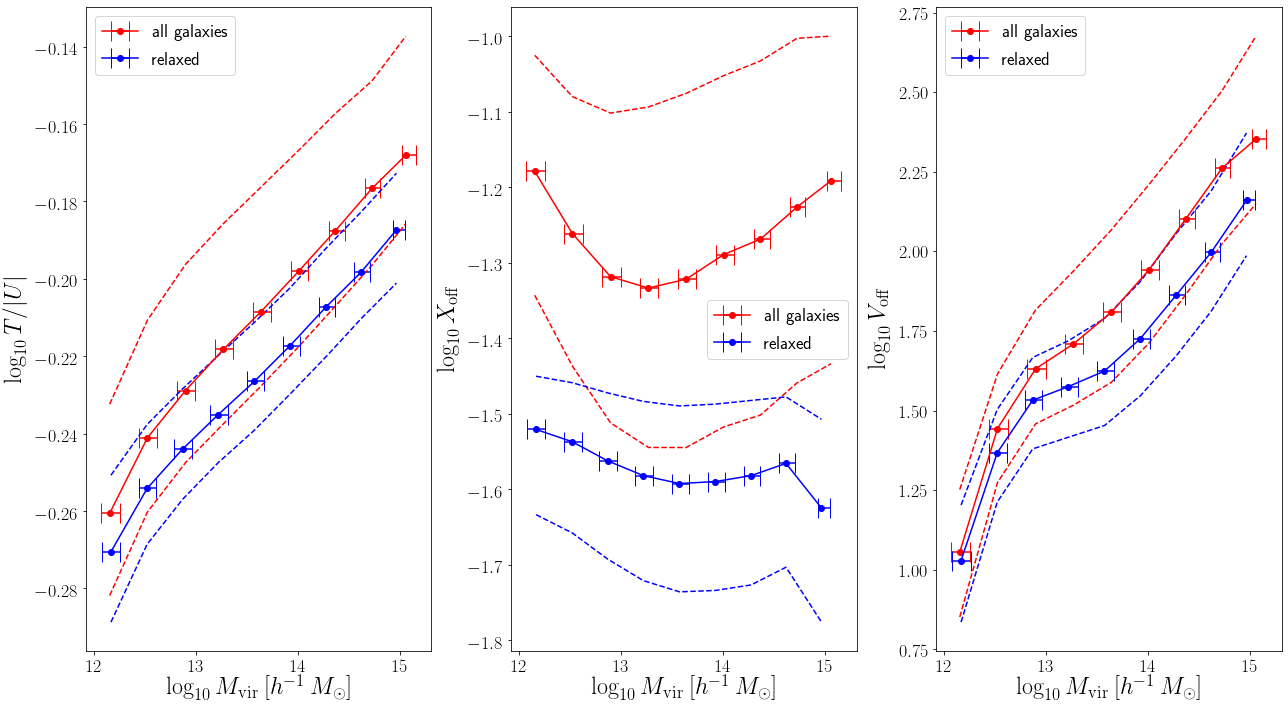

In [216]:
fig, axs = plt.subplots(1,3, figsize=(18,10))
axes = axs.flatten()


scatter_binning(np.log10(cat['mvir']), np.log10(cat['T/|U|']), nxbins=10, ax=axes[0],
               xlabel=to_latex('mvir', True, True), ylabel=to_latex('T/|U|',True), xlabel_size=24, ylabel_size=24,
               tick_size=18, no_bars=True, show_lines=True, legend_label='all galaxies')

scatter_binning(np.log10(cat[relaxed]['mvir']), np.log10(cat[relaxed]['T/|U|']), nxbins=10, ax=axes[0],
               xlabel=to_latex('mvir', True, True), ylabel=to_latex('T/|U|',True), xlabel_size=24, ylabel_size=24,
               tick_size=18, no_bars=True, show_lines=True, legend_label='relaxed', legend_size=18, color='blue'
               )

scatter_binning(np.log10(cat['mvir']), np.log10(cat['Xoff']), nxbins=10, ax=axes[1], 
                xlabel=to_latex('mvir', True,True), ylabel=to_latex('Xoff',True), xlabel_size=24, ylabel_size=24,
               tick_size=18, no_bars=True, show_lines=True, legend_label='all galaxies')

scatter_binning(np.log10(cat[relaxed]['mvir']), np.log10(cat[relaxed]['Xoff']), nxbins=10, ax=axes[1], 
                xlabel=to_latex('mvir', True,True), ylabel=to_latex('Xoff',True), xlabel_size=24, ylabel_size=24,
               tick_size=18, no_bars=True, show_lines=True, legend_label='relaxed', legend_size=18, color='blue')

scatter_binning(np.log10(cat['mvir']), np.log10(cat['Voff']), nxbins=10, ax=axes[2], 
                xlabel=to_latex('mvir', True,True), ylabel=to_latex('Voff',True), xlabel_size=24, ylabel_size=24,
                tick_size=18, no_bars=True, show_lines=True, legend_label='all galaxies')

scatter_binning(np.log10(cat[relaxed]['mvir']), np.log10(cat[relaxed]['Voff']), nxbins=10, ax=axes[2], 
                xlabel=to_latex('mvir', True,True), ylabel=to_latex('Voff',True), xlabel_size=24, ylabel_size=24,
               tick_size=18, no_bars=True, show_lines=True, legend_label='relaxed', legend_size=18, color='blue')

plt.tight_layout()

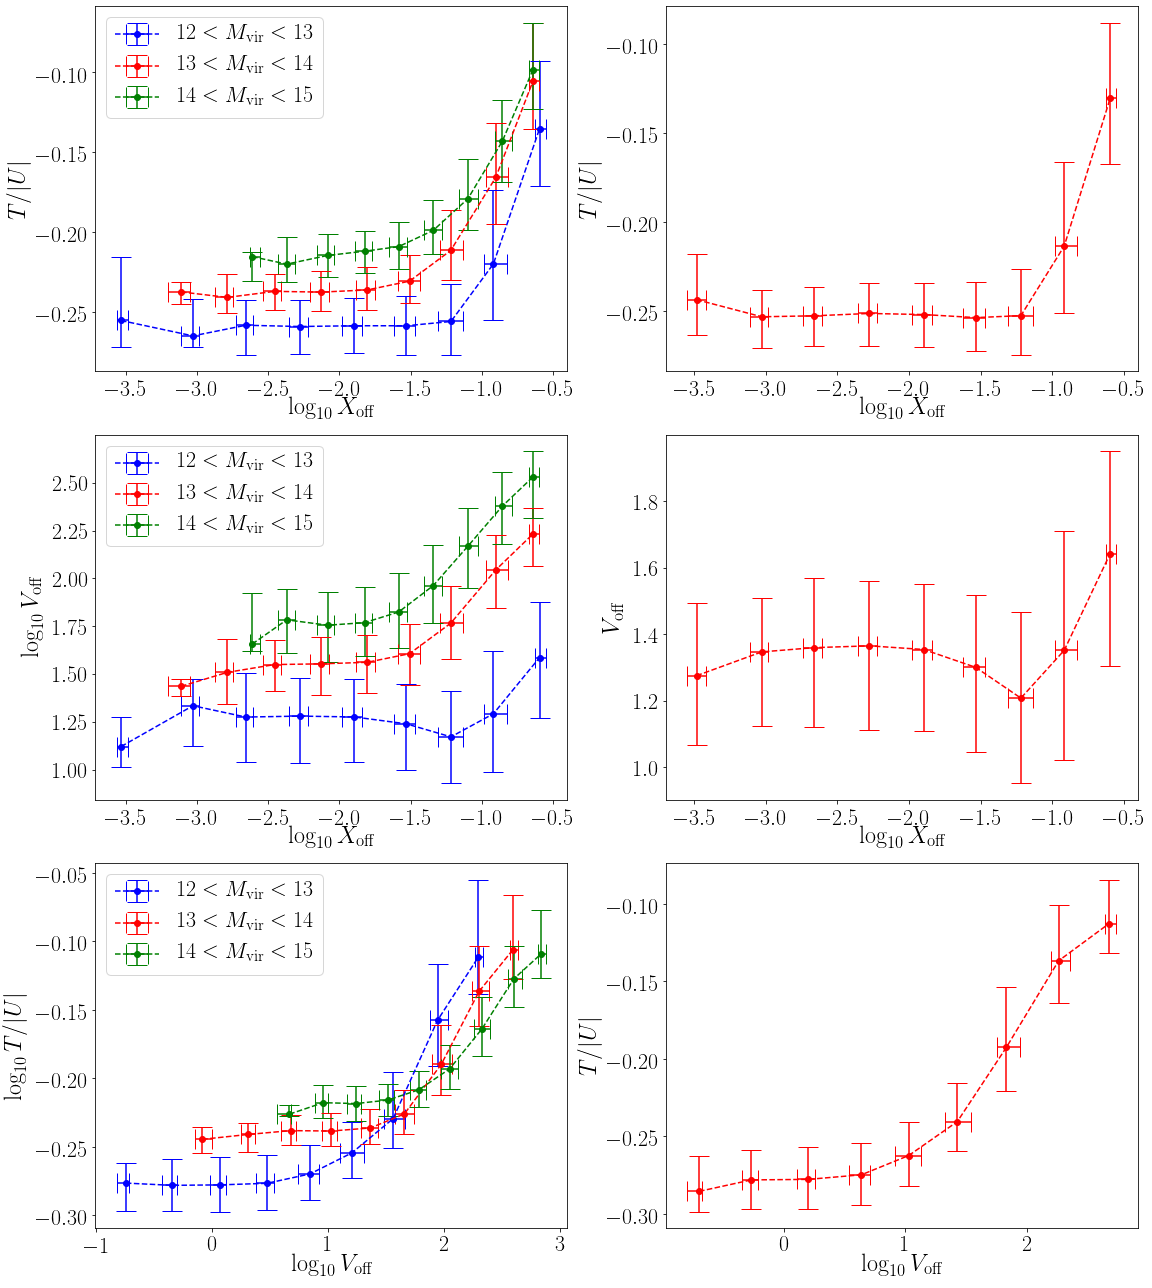

In [219]:
fig, axs=  plt.subplots(3,2, figsize=(16,18))
axes = axs.flatten()
plotting.binning3d_mass(cat, axes[0], scatter_binning, 'Xoff', 'T/|U|', mods=[lambda x: np.log10(x), lambda x: np.log10(x)],
               plot_kwargs=dict(nxbins=10, xlabel=plotting.to_latex('Xoff',True), ylabel=plotting.to_latex('T/|U|'), 
                             tick_size=22, xlabel_size=24, ylabel_size=24), legend_size=22
              )
plotting.scatter_binning(np.log10(cat['Xoff']), np.log10(cat['T/|U|']), axes[1], 
                         xlabel=plotting.to_latex('Xoff',True), ylabel=plotting.to_latex('T/|U|'),
                        tick_size=22, xlabel_size=24, ylabel_size=24)

plotting.binning3d_mass(cat, axes[2], scatter_binning, 'Xoff', 'Voff', mods=[lambda x: np.log10(x), lambda x: np.log10(x)],
               plot_kwargs=dict(nxbins=10, xlabel=plotting.to_latex('Xoff',True), ylabel=plotting.to_latex('Voff',True), 
                             tick_size=22, xlabel_size=24, ylabel_size=24), legend_size=22
              )

plotting.scatter_binning(np.log10(cat['Xoff']), np.log10(cat['Voff']), axes[3], xlabel=plotting.to_latex('Xoff',True), 
                         ylabel=plotting.to_latex('Voff'), tick_size=22, xlabel_size=24, ylabel_size=24)

plotting.binning3d_mass(cat, axes[4], scatter_binning, 'Voff', 'T/|U|', mods=[lambda x: np.log10(x), lambda x: np.log10(x)],
               plot_kwargs=dict(nxbins=10, xlabel=plotting.to_latex('Voff',True), ylabel=plotting.to_latex('T/|U|',True), 
                             tick_size=22, xlabel_size=24, ylabel_size=24), legend_size=22
              )

plotting.scatter_binning(np.log10(cat['Voff']), np.log10(cat['T/|U|']), axes[5], xlabel=plotting.to_latex('Voff',True), 
                         ylabel=plotting.to_latex('T/|U|'), tick_size=22, xlabel_size=24, ylabel_size=24)
plt.tight_layout()
# scatter_binning(np.log10(cat[]))

# PCA 

In [78]:
from sklearn.decomposition import PCA

In [79]:
params = ['mvir', 'cvir','Spin', 'q','phi_l', 'Xoff', 'T/|U|'
         ]

In [80]:
pca = PCA(n_components=4)

In [81]:
#normalize and take log.
#cuts on mass >= 12 once we get z= 0 catalogue and different fixed mass regimes too.  
# remove extreme outliers too. 
X = np.zeros((len(params), len(cat['mvir'])))
for i, param in enumerate(params): 
    x = np.log10(cat[param])
    px = (x - np.mean(x))/ np.std(x)
    X[i] = px 
    

In [85]:
pca.fit(X.T)

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [88]:
np.set_printoptions(threshold=50)
print(params)
print('singular values:', pca.singular_values_)
print('explained variance ratio:', pca.explained_variance_ratio_)  
print('components \n ', pca.components_)

['mvir', 'cvir', 'Spin', 'q', 'phi_l', 'Xoff', 'T/|U|']
singular values: [3081.55348112 2070.16598156 1929.0333174  1694.26214517]
explained variance ratio: [0.36195806 0.16335377 0.14183986 0.1094158 ]
components 
  [[ 0.25606243 -0.45008324  0.24390843 -0.46015147  0.04808422  0.50791403
   0.44759094]
 [ 0.66746691  0.16125609 -0.60903099  0.19212952 -0.23274213  0.07853374
   0.24559205]
 [-0.2126435  -0.11469082  0.05424395 -0.10650889 -0.96184821  0.01355982
  -0.04479243]
 [-0.39020568 -0.25759937 -0.72542735 -0.47783302  0.12975934 -0.08974518
  -0.04383112]]


# dynamical comparisons 

Useful to compare to the Power et al. 2011 paper

In [21]:
params = ['mvir', 'cvir' , 'T/|U|', 'Xoff', 'Voff', 'Spin', 'q', 'phi_l', 'Acc_Rate_Inst',
          'Acc_Rate_1*Tdyn','Acc_Rate_2*Tdyn']

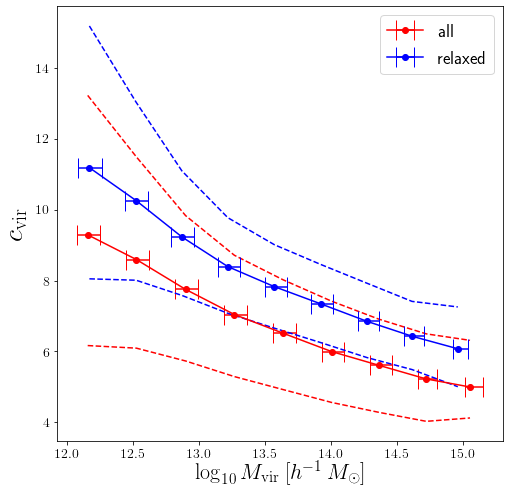

In [32]:
#not sure what Halfmass_Scale corresponds to but maybe inverse of (1+zform)^(-1)? 
#sanity check. 
fig, ax = plt.subplots(1,1,figsize=(8,8))
scatter_binning(np.log10(cat['mvir']), cat['cvir'], ax, xlabel=to_latex('mvir',True), ylabel=to_latex('cvir'),
               xlabel_size=22, ylabel_size=28, legend_label='all', no_bars=True, show_lines=True)

scatter_binning(np.log10(cat[relaxed]['mvir']), cat[relaxed]['cvir'], ax, xlabel=to_latex('mvir',True), ylabel=to_latex('cvir'),
               xlabel_size=22, ylabel_size=28, color='blue', legend_label='relaxed', no_bars=True, show_lines=True)

ax.legend(prop={'size':18}, loc='best')

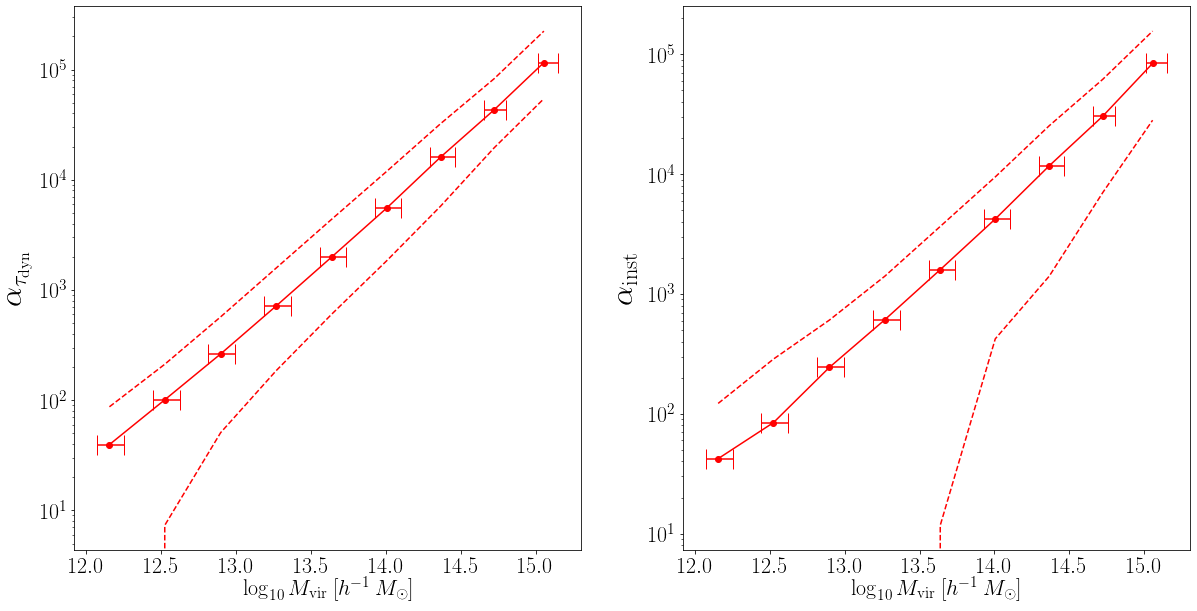

In [34]:
#accretion rate and mass. 
fig, axs = plt.subplots(1,2,figsize=(20,10))

scatter_binning(np.log10(cat['mvir']), cat['Acc_Rate_1*Tdyn'],ax=axs[0], xlabel=to_latex('mvir',True), 
                ylabel=to_latex('Acc_Rate_1*Tdyn'), xlabel_size=22, ylabel_size=32, tick_size=22, no_bars=True, 
               show_lines=True)
axs[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axs[0].yaxis.get_offset_text().set_fontsize(24)
axs[0].set_yscale('log',nonposy='clip')

# axs[0].set_yscale('log')

scatter_binning(np.log10(cat['mvir']), cat['Acc_Rate_Inst'],ax=axs[1], xlabel=to_latex('mvir',True), 
                ylabel=to_latex('Acc_Rate_Inst'), xlabel_size=22, ylabel_size=32, tick_size=22, 
               no_bars=True, show_lines=True)
axs[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axs[1].yaxis.get_offset_text().set_fontsize(24)
axs[1].set_yscale('log',nonposy='clip')
# scatter_binning(np.log10(cat['mvir']), np.log10(cat['Acc_Rate_1*Tdyn']) )

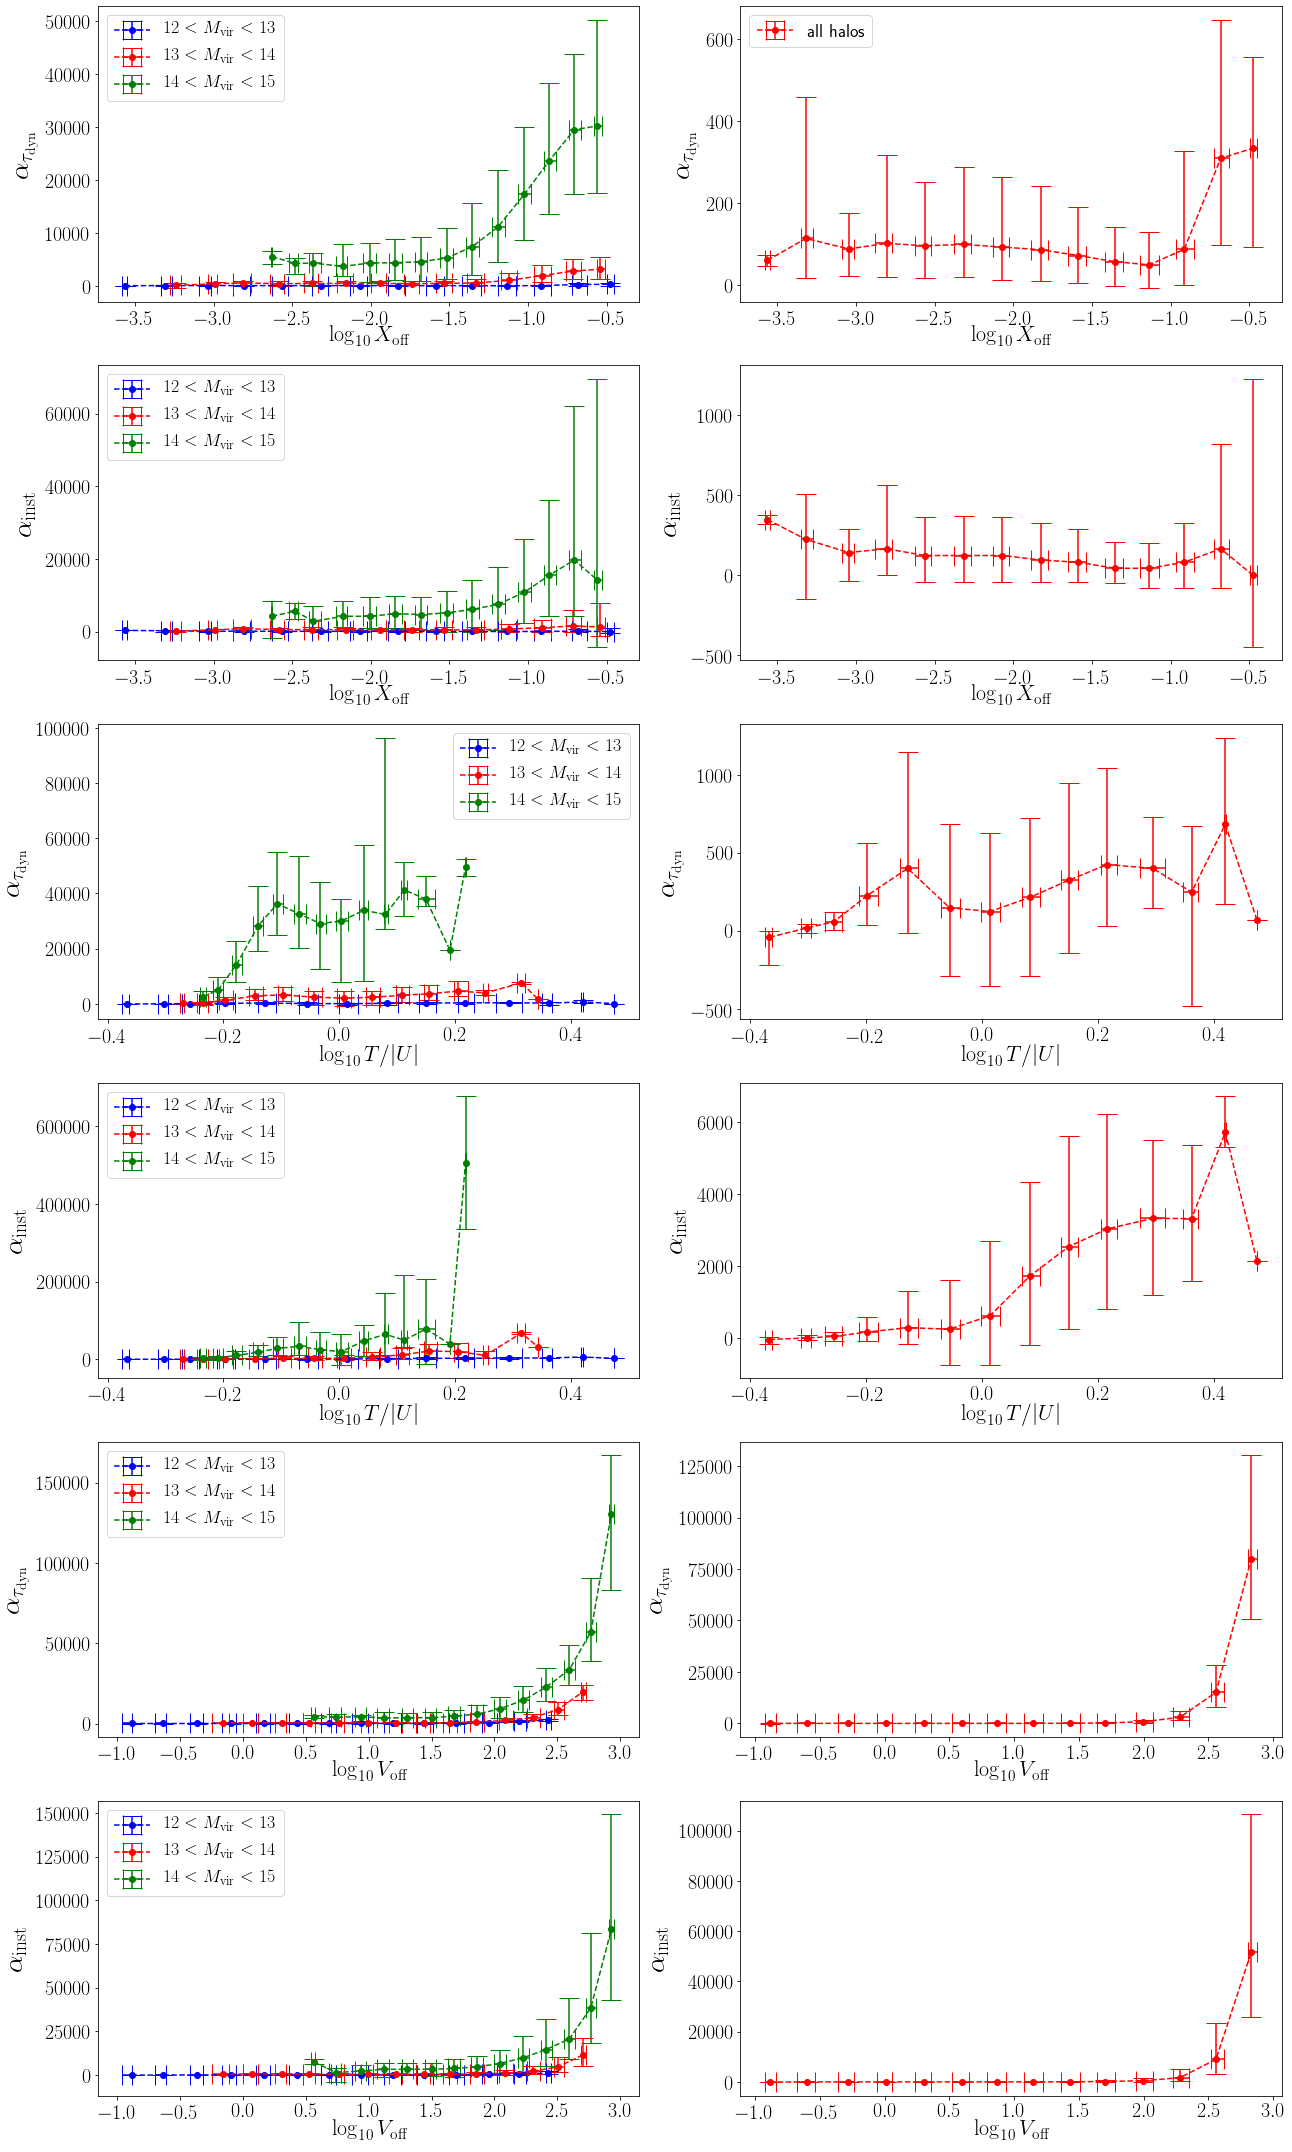

In [222]:
fig, axs = plt.subplots(6,2,figsize=(18,30))
axes = axs.flatten()
binning3d_mass(cat, axes[0], scatter_binning, 'Xoff', 'Acc_Rate_1*Tdyn', 
                   mods=[lambda x: np.log10(x), lambda x: x],
                   plot_kwargs=dict(nxbins=15,
                   xlabel=to_latex('Xoff', True), ylabel=to_latex('Acc_Rate_1*Tdyn'), xlabel_size=22, 
                    ylabel_size=28, tick_size=20))

scatter_binning(np.log10(cat['Xoff']), cat['Acc_Rate_1*Tdyn'],ax=axes[1], nxbins=15,
                   xlabel=to_latex('Xoff',True), ylabel=to_latex('Acc_Rate_1*Tdyn'), xlabel_size=22, 
                ylabel_size=28, tick_size=20, legend_label='all halos',legend_size=18)

binning3d_mass(cat, axes[2], scatter_binning, 'Xoff', 'Acc_Rate_Inst', 
                   mods=[lambda x: np.log10(x), lambda x: x],
                   plot_kwargs=dict(nxbins=15,
                   xlabel=to_latex('Xoff', True), ylabel=to_latex('Acc_Rate_Inst'), xlabel_size=22, 
                    ylabel_size=28, tick_size=20))

scatter_binning(np.log10(cat['Xoff']), cat['Acc_Rate_Inst'], ax=axes[3], nxbins=15,
xlabel=to_latex('Xoff',True), ylabel=to_latex('Acc_Rate_Inst'), xlabel_size=22, 
                ylabel_size=28, tick_size=20)


binning3d_mass(cat, axes[4], scatter_binning, 'T/|U|', 'Acc_Rate_1*Tdyn', 
                   mods=[lambda x: np.log10(x), lambda x: x],
                   plot_kwargs=dict(nxbins=15,
                   xlabel=to_latex('T/|U|', True), ylabel=to_latex('Acc_Rate_1*Tdyn'), xlabel_size=22, 
                    ylabel_size=28, tick_size=20))

scatter_binning(np.log10(cat['T/|U|']), cat['Acc_Rate_1*Tdyn'], ax=axes[5], nxbins=15,
xlabel=to_latex('T/|U|',True), ylabel=to_latex('Acc_Rate_1*Tdyn'), xlabel_size=22, 
                ylabel_size=28, tick_size=20)

binning3d_mass(cat, axes[6], scatter_binning, 'T/|U|', 'Acc_Rate_Inst', 
                   mods=[lambda x: np.log10(x), lambda x: x],
                   plot_kwargs=dict(nxbins=15,
                   xlabel=to_latex('T/|U|', True), ylabel=to_latex('Acc_Rate_Inst'), xlabel_size=22, 
                    ylabel_size=28, tick_size=20))

scatter_binning(np.log10(cat['T/|U|']), cat['Acc_Rate_Inst'], ax=axes[7], nxbins=15,
xlabel=to_latex('T/|U|',True), ylabel=to_latex('Acc_Rate_Inst'), xlabel_size=22, 
                ylabel_size=28, tick_size=20)


binning3d_mass(cat, axes[8], scatter_binning, 'Voff', 'Acc_Rate_1*Tdyn', 
                   mods=[lambda x: np.log10(x), lambda x: x],
                   plot_kwargs=dict(nxbins=15,
                   xlabel=to_latex('Voff', True), ylabel=to_latex('Acc_Rate_1*Tdyn'), xlabel_size=22, 
                    ylabel_size=28, tick_size=20))

scatter_binning(np.log10(cat['Voff']), cat['Acc_Rate_1*Tdyn'], ax=axes[9], nxbins=15,
xlabel=to_latex('Voff',True), ylabel=to_latex('Acc_Rate_1*Tdyn'), xlabel_size=22, 
                ylabel_size=28, tick_size=20)

binning3d_mass(cat, axes[10], scatter_binning, 'Voff', 'Acc_Rate_Inst', 
                   mods=[lambda x: np.log10(x), lambda x: x],
                   plot_kwargs=dict(nxbins=15,
                   xlabel=to_latex('Voff', True), ylabel=to_latex('Acc_Rate_Inst'), xlabel_size=22, 
                    ylabel_size=28, tick_size=20))

scatter_binning(np.log10(cat['Voff']), cat['Acc_Rate_Inst'], ax=axes[11], nxbins=15,
xlabel=to_latex('Voff',True), ylabel=to_latex('Acc_Rate_Inst'), xlabel_size=22, 
                ylabel_size=28, tick_size=20)


plt.tight_layout()

In [ ]:
# conclusion: eta is much more sensitive to recent accretion 
# should look at this for different mass ranges (decades)

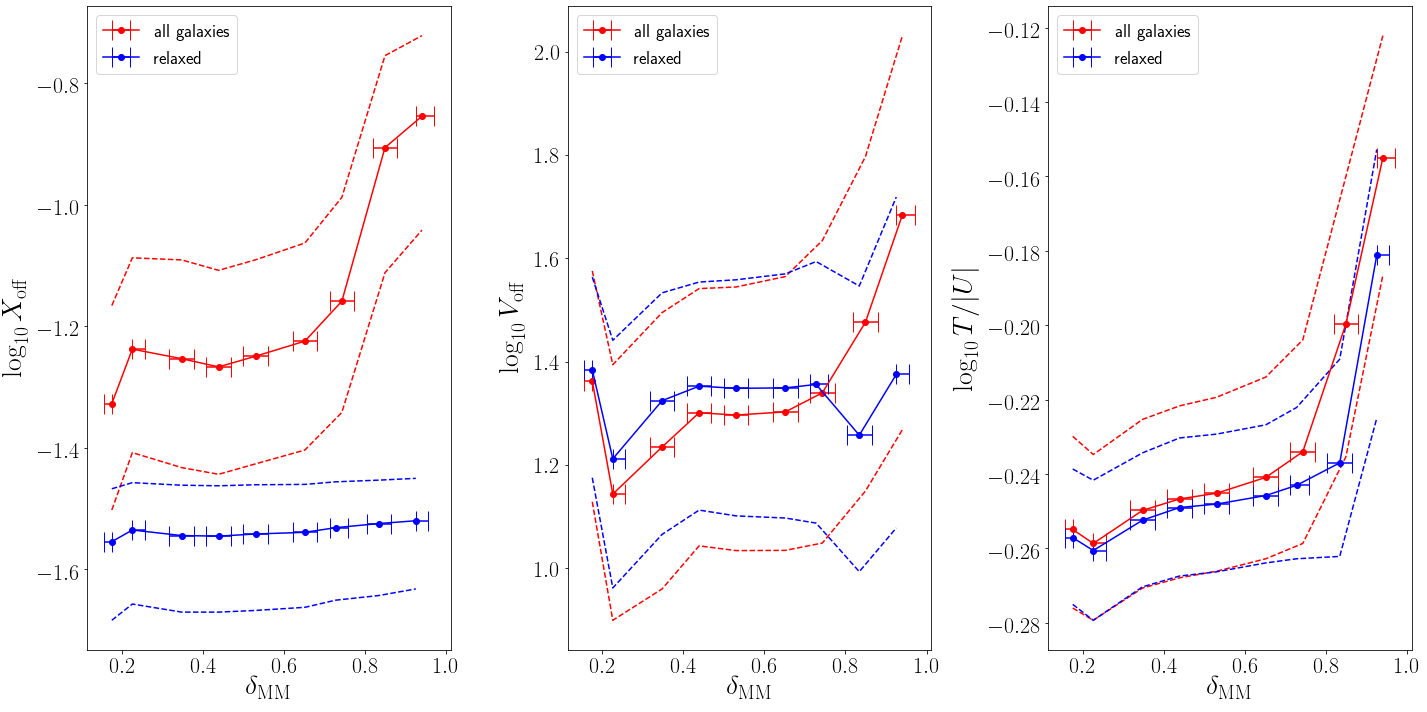

In [232]:
fig, axs = plt.subplots(1,3,figsize=(20,10))
axes = axs.flatten()

scatter_binning( cat['scale_of_last_MM'], np.log10(cat['Xoff']),ax=axes[0], 
                nxbins=10, xlabel=to_latex('scale_of_last_MM'), ylabel=to_latex('Xoff',True),
                xlabel_size=28, ylabel_size=28, tick_size=22, no_bars=True, show_lines=True,
                legend_label='all galaxies')

scatter_binning( cat[relaxed]['scale_of_last_MM'], np.log10(cat[relaxed]['Xoff']),ax=axes[0], 
                nxbins=10, xlabel=to_latex('scale_of_last_MM'), ylabel=to_latex('Xoff',True),
                xlabel_size=28, ylabel_size=28, tick_size=22, no_bars=True, show_lines=True, color='blue',
                legend_label='relaxed')

scatter_binning( cat['scale_of_last_MM'], np.log10(cat['Voff']),ax=axes[1], 
                nxbins=10, xlabel=to_latex('scale_of_last_MM'), ylabel=to_latex('Voff',True),
                xlabel_size=28, ylabel_size=28, tick_size=22, no_bars=True, show_lines=True,
                legend_label='all galaxies')

scatter_binning( cat[relaxed]['scale_of_last_MM'], np.log10(cat[relaxed]['Voff']),ax=axes[1], 
                nxbins=10, xlabel=to_latex('scale_of_last_MM'), ylabel=to_latex('Voff',True),
                xlabel_size=28, ylabel_size=28, tick_size=22, no_bars=True, show_lines=True, color='blue',
                legend_label='relaxed')

scatter_binning( cat['scale_of_last_MM'], np.log10(cat['T/|U|']),ax=axes[2], 
                nxbins=10, xlabel=to_latex('scale_of_last_MM'), ylabel=to_latex('T/|U|',True),
                xlabel_size=28, ylabel_size=28, tick_size=22, no_bars=True, show_lines=True,
                legend_label='all galaxies')

scatter_binning( cat[relaxed]['scale_of_last_MM'], np.log10(cat[relaxed]['T/|U|']),ax=axes[2], 
                nxbins=10, xlabel=to_latex('scale_of_last_MM'), ylabel=to_latex('T/|U|',True),
                xlabel_size=28, ylabel_size=28, tick_size=22, no_bars=True, show_lines=True, color='blue',
                legend_label='relaxed')

# scatter_binning( cat['scale_of_last_MM'], np.log10(cat['Xoff']),ax=axes[0], 
#                 nxbins=10, xlabel=to_latex('scale_of_last_MM'), ylabel=to_latex('Xoff',True))

# scatter_binning( cat['scale_of_last_MM'], np.log10(cat['T/|U|']),ax=axes[1], nxbins=10)
plt.tight_layout()

# Plot with shapes 

In [ ]:
#hypothesis: T/U related to shape. 

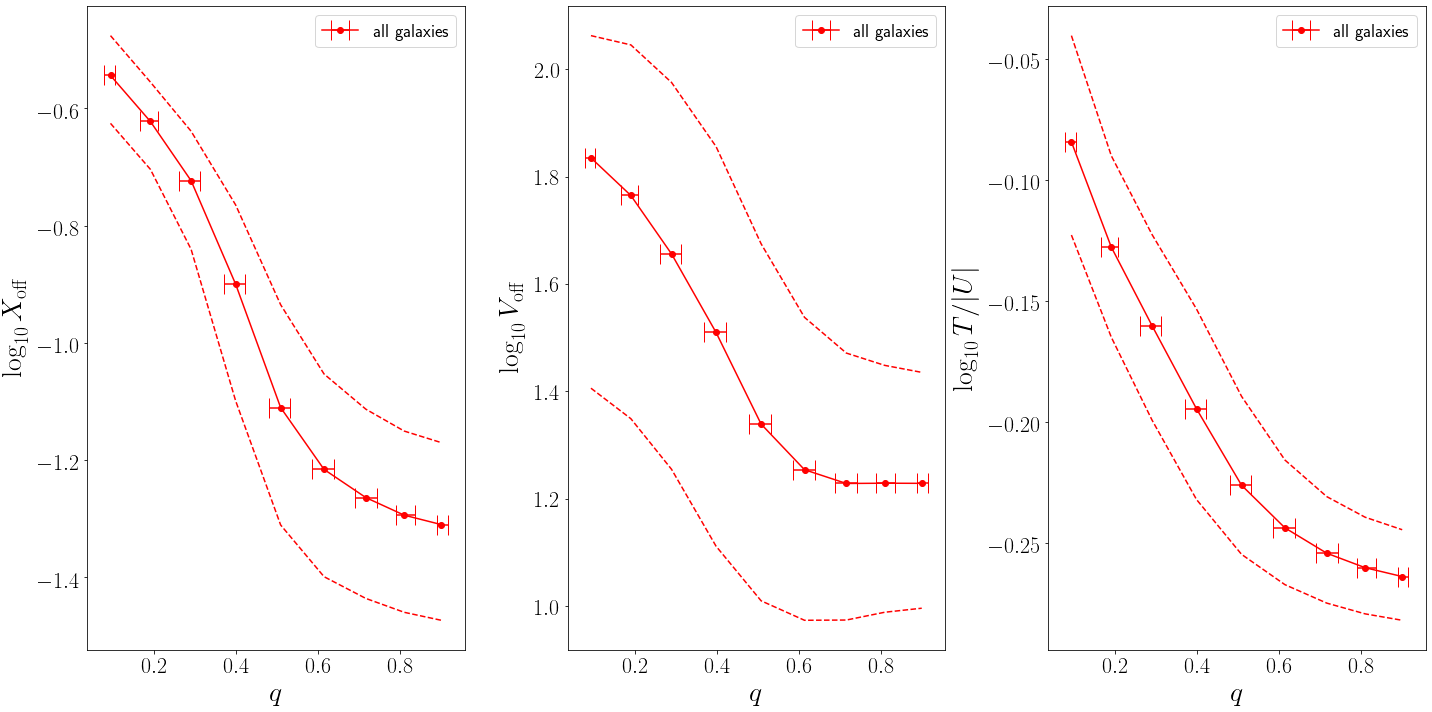

In [236]:
fig, axs = plt.subplots(1,3,figsize=(20,10))
axes = axs.flatten()

scatter_binning( cat['q'], np.log10(cat['Xoff']),ax=axes[0], 
                nxbins=10, xlabel=to_latex('q'), ylabel=to_latex('Xoff',True),
                xlabel_size=28, ylabel_size=28, tick_size=22, no_bars=True, show_lines=True,
                legend_label='all galaxies')

scatter_binning( cat['q'], np.log10(cat['Voff']),ax=axes[1], 
                nxbins=10, xlabel=to_latex('q'), ylabel=to_latex('Voff',True),
                xlabel_size=28, ylabel_size=28, tick_size=22, no_bars=True, show_lines=True,
                legend_label='all galaxies')


scatter_binning( cat['q'], np.log10(cat['T/|U|']),ax=axes[2], 
                nxbins=10, xlabel=to_latex('q'), ylabel=to_latex('T/|U|',True),
                xlabel_size=28, ylabel_size=28, tick_size=22, no_bars=True, show_lines=True,
                legend_label='all galaxies')

plt.tight_layout()

In [ ]:
#ToDo: 
#add calculating the substructure fraction. 
#so at different time scales the universse is denser so different things might relax quicker, 
#look only at most massive progenitor. 
#vrms as measure of relaxedness 